# Image Classification using ImageNette + depth

> Image Classification using ImageNette + depth


- skip_showdoc: true
- skip_exec: true

## Images

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

from datetime import datetime
from tqdm import tqdm 
import matplotlib.pyplot as plt
import timm
import numpy as np


In [ ]:
transform_default = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

In [ ]:
# Download and load the Imagenette dataset
train_dataset = datasets.Imagenette(root='Data',
                                    split='train',
                                    # download=True,
                                    transform=transform_default,
                                    )


# Download and load the Imagenette dataset
test_dataset = datasets.Imagenette(root='Data',
                                  split='val',
                                  # download=True,
                                  transform=transform_default,
                                 )

In [ ]:
# Define a function to display images
def show_image(dataset):
    # Access an image and its label from the dataset
    image, label = dataset
    
    # Convert the image tensor to a NumPy array
    image_np = image[:3].numpy().transpose((1, 2, 0))

    # Display the image using Matplotlib
    plt.imshow(image_np.clip(0,1))
    plt.axis('off')
    plt.title(f' {train_dataset.classes[label][0]}')
    plt.show()
    
   
# Define a function to display images
def show_images(images, labels, **kwargs):
    nrows = int(np.ceil(np.sqrt(len(images))))
    ncols = int(np.ceil(len(images)/nrows))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12),  **kwargs)
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    for ax, image, label in zip(axes.flat, images, labels):
        # Convert image to numpy array and adjust pixel values
        img_np = image[:3].numpy().transpose((1, 2, 0))
        
        # Display image
        ax.imshow(img_np.clip(0,1))
        ax.axis('off')
        ax.set_title(f' {train_dataset.classes[label][0]}')
    for ax in axes.flat[len(images):]:
        ax.axis('off')
        
    plt.show()

In [ ]:
image, label = train_dataset[2]

In [ ]:
type(image)

torch.Tensor

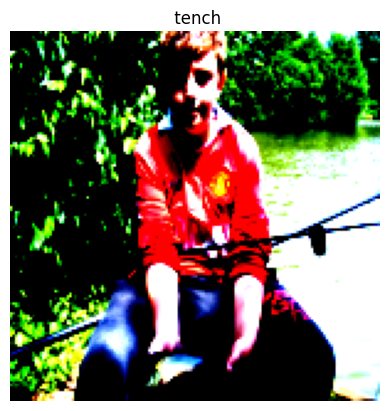

In [ ]:
show_image(train_dataset[2])

## Test Transform

In [ ]:
import torch
import torchvision.transforms.functional as TF

class AddGrayscaleChannel(object):
    def __init__(self):
        super().__init__()
    
    def __call__(self, img):
        # Convert the image to grayscale
        gray_img = TF.rgb_to_grayscale(img)
        
        # Concatenate the grayscale image with the original image along the fourth dimension
        img_with_gray_channel = torch.cat((img, gray_img), dim=0)
        
        return img_with_gray_channel

    def __repr__(self):
        return self.__class__.__name__ + '()'



## FFT Transform

In [ ]:
class ComputeFFT(object):
    def __init__(self):
        super().__init__()
    
    def __call__(self, image):
        # Convert the color image to grayscale
        grayscale_image = TF.rgb_to_grayscale(image).squeeze()
        
        # Convert the grayscale image to tensor and apply FFT
        fft_result = torch.fft.fft2(grayscale_image)
        
        # Compute magnitude spectrum
        magnitude_spectrum = torch.log(torch.abs(fft_result) + 1)
        
        # Compute phase spectrum
        phase_spectrum = torch.angle(fft_result)
        
        combined_image = torch.cat((image, magnitude_spectrum.unsqueeze(0), phase_spectrum.unsqueeze(0)), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


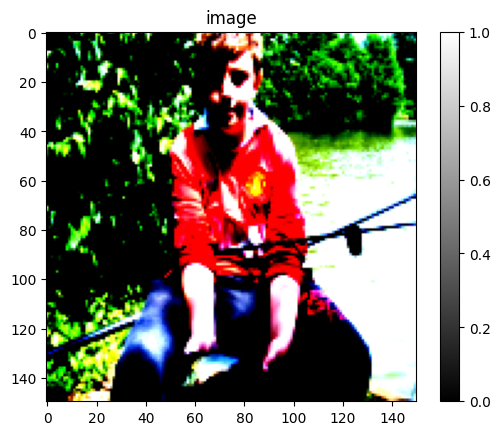

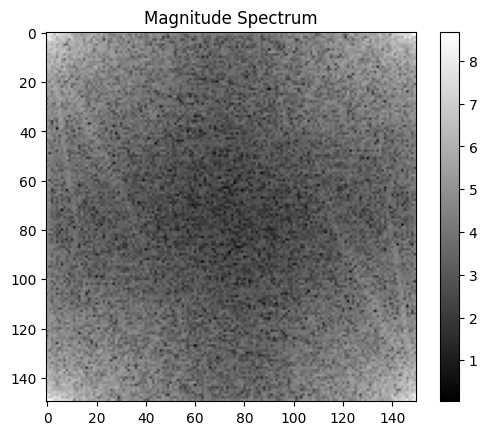

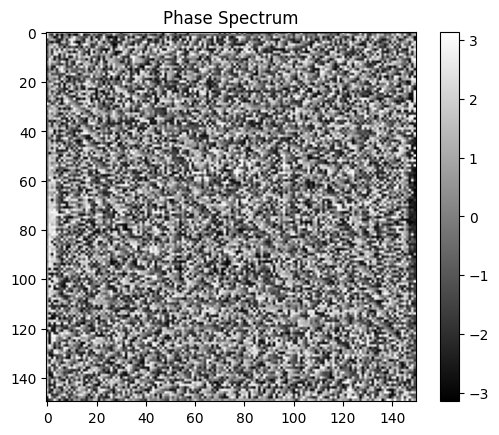

In [ ]:
transform = ComputeFFT()
new_image = transform(image)
transposed_image = torch.transpose(new_image[:3], 0, 2).transpose(0, 1)

plt.imshow(transposed_image, cmap='gray')
plt.title('image')
plt.colorbar()
plt.show()

plt.imshow(new_image[3], cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()

# Visualize phase spectrum
plt.imshow(new_image[4], cmap='gray')
plt.title('Phase Spectrum')
plt.colorbar()
plt.show()

In [ ]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/ben/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/ben/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
class ComputeDepth(object):
    def __init__(self, model, transform, device = "cuda"):
        super().__init__()
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.model.eval()
        self.transform = transform
    
    def __call__(self, image):
        input_image = image.to('cpu').squeeze().numpy().transpose(1, 2, 0)
        # input_image = np.array(image)
        input_batch = transform(input_image).to(self.device)
        
        with torch.no_grad():
            prediction = self.model(input_batch)
            
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=input_image.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze(0)
            prediction = prediction.to('cpu')

        prediction_mean = torch.mean(prediction)
        prediction_std = torch.std(prediction)
        
        # Calculate the scaling factors for normalization
        scale_factor = 0.225 / prediction_std
        bias = 0.45 - prediction_mean * scale_factor
        
        # Normalize the tensor to the desired mean and standard deviation
        prediction = prediction * scale_factor + bias
        
        combined_image = torch.cat((image, prediction), dim=0)

        return combined_image

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
image, label = train_dataset[2]

In [ ]:
type(image)

torch.Tensor

In [ ]:
transform_depth = ComputeDepth(midas, transform = transform, device = "cpu")
new_image = transform_depth(image)
transposed_image = torch.transpose(new_image[:3], 0, 2).transpose(0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


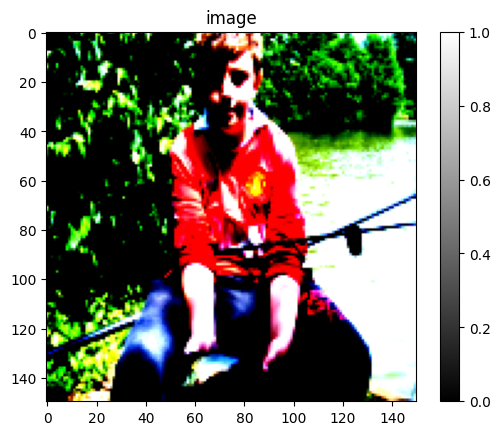

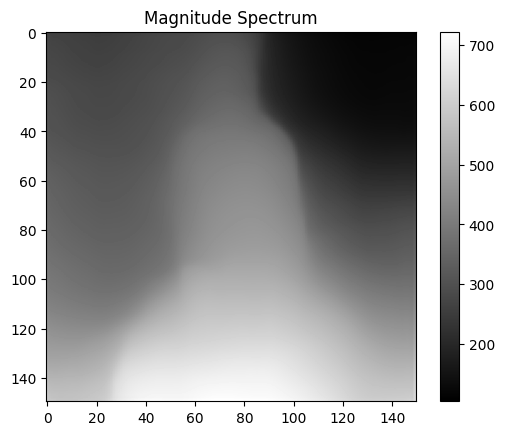

In [ ]:
plt.imshow(transposed_image, cmap='gray')
plt.title('image')
plt.colorbar()
plt.show()

plt.imshow(new_image[3], cmap='gray')
plt.title('Magnitude Spectrum')
plt.colorbar()
plt.show()